In [85]:
import pandas as pd
import numpy as np
from plotly.graph_objs import *
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional
from read_bucket import ReadDataFrame
# Data Visualization using plotly
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "vscode"
pio.renderers.default = "svg"
init_notebook_mode(connected=True)

In [86]:
r = ReadDataFrame(bucket_name='estac-data', file_name='estac_data.csv')

In [87]:
data = r.read_dataframe()

Fetching file from s3://estac-data/estac_data.csv
Loaded 165350 records from s3://estac-data/estac_data.csv


In [88]:
past_record = pd.read_csv('estac_data.csv')

In [89]:
combined_df = pd.concat([past_record,data], ignore_index=True)

In [90]:
df = combined_df.drop_duplicates(subset=['device_time'],keep='last')

In [91]:
df.shape

(201161, 3)

In [92]:
df.tail()

device_time  humidity  temperature
201159  2025-11-19 22:30:54      55.9         24.9
201160  2025-11-19 22:31:09      55.7         24.9
201161  2025-11-19 22:31:24      55.3         24.9
201162  2025-11-19 22:31:39      55.0         24.8
201163  2025-11-19 22:31:54      54.7         24.8

In [93]:
df['device_time'] = pd.to_datetime(df['device_time'])

C:\Users\Vibhor\AppData\Local\Temp\ipykernel_2772\2466456670.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
df['hour'] = df['device_time'].dt.hour

C:\Users\Vibhor\AppData\Local\Temp\ipykernel_2772\1669095676.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [95]:
# df.to_csv("estac_records.csv", index=False)

In [96]:

df.set_index('device_time', inplace=True)

In [97]:
df.head()

humidity  temperature  hour
device_time                                     
2025-10-05 00:05:20      80.9         27.0     0
2025-10-05 00:05:33      80.9         27.0     0
2025-10-05 00:05:47      80.9         27.0     0
2025-10-05 00:06:00      80.9         27.0     0
2025-10-05 00:06:14      80.9         27.0     0

In [98]:
# Resample hourly
hourly = df.resample('h').mean()

In [99]:
hourly = hourly.reset_index()

In [100]:
hourly = hourly.dropna()

In [101]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1014 entries, 0 to 1102
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   device_time  1014 non-null   datetime64[ns]
 1   humidity     1014 non-null   float64       
 2   temperature  1014 non-null   float64       
 3   hour         1014 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 39.6 KB


In [102]:
hourly['temperature'] = hourly['temperature'].round(1)
hourly['humidity'] = hourly['humidity'].round(1)


In [103]:
hourly['hour'] = hourly['hour'].astype(int)

In [104]:
# Rolling averages (smooth short-term fluctuations)
hourly['Temp_MA_2'] = hourly['temperature'].rolling(window=2).mean()
hourly['Humidity_MA_2'] = hourly['humidity'].rolling(window=2).mean()

In [105]:
# Rate of change (trend direction and strength)
hourly['Temp_rate'] = hourly['Temp_MA_2'].diff()
hourly['Humidity_rate'] = hourly['Humidity_MA_2'].diff()

In [106]:
def classify_phases(
    df, 
    temp_rate_col="Temp_rate", 
    humidity_rate_col="Humidity_rate",
    threshold=1.5,
    temp_phase_col="Temp_phase",
    humidity_phase_col="Humidity_phase"
):
    """
    Classify Heating/Cooling and Moistening/Drying phases in a dataframe.

    Parameters
    ----------
    df : pandas DataFrame
        Input dataframe.

    temp_rate_col : str
        Column name containing temperature rate values.

    humidity_rate_col : str
        Column name containing humidity rate values.

    threshold : float
        Rate threshold for detecting meaningful changes.

    temp_phase_col : str
        Output column name for temperature phase labels.

    humidity_phase_col : str
        Output column name for humidity phase labels.

    Returns
    -------
    df : pandas DataFrame
        DataFrame with two new columns: temp_phase_col and humidity_phase_col.
    """

    # Temperature phases
    df[temp_phase_col] = np.where(
        df[temp_rate_col] > threshold, "Heating",
        np.where(df[temp_rate_col] < -threshold, "Cooling", "Neutral")
    )

    # Humidity phases
    df[humidity_phase_col] = np.where(
        df[humidity_rate_col] > threshold, "Moistening",
        np.where(df[humidity_rate_col] < -threshold, "Drying", "Moderate")
    )

    return df

In [107]:
identify_phase = classify_phases(df=hourly, threshold=0.05)

In [108]:
hourly

device_time  humidity  temperature  hour  Temp_MA_2  \
0    2025-10-05 00:00:00      81.0         27.0     0        NaN   
1    2025-10-05 01:00:00      81.3         27.0     1      27.00   
2    2025-10-05 02:00:00      81.6         27.0     2      27.00   
3    2025-10-05 03:00:00      81.8         27.0     3      27.00   
4    2025-10-05 04:00:00      82.0         27.0     4      27.00   
...                  ...       ...          ...   ...        ...   
1098 2025-11-19 18:00:00      51.0         25.7    18      25.40   
1099 2025-11-19 19:00:00      49.5         25.8    19      25.75   
1100 2025-11-19 20:00:00      47.2         25.9    20      25.85   
1101 2025-11-19 21:00:00      49.5         25.6    21      25.75   
1102 2025-11-19 22:00:00      48.1         25.8    22      25.70   

      Humidity_MA_2  Temp_rate  Humidity_rate Temp_phase Humidity_phase  
0               NaN        NaN            NaN    Neutral       Moderate  
1             81.15        NaN            NaN    Neutral       Moderate  
2             81.45       0.00           0.30    Neutral     Moistening  
3             81.70       0.00           0.25    Neutral     Moistening  
4             81.90       0.00           0.20    Neutral     Moistening  
...             ...        ...            ...        ...            ...  
1098          50.20       0.50           3.05    Heating     Moistening  
1099          50.25       0.35           0.05    Heating     Moistening  
1100          48.35       0.10          -1.90    Heating         Drying  
1101          48.35      -0.10           0.00    Cooling       Moderate  
1102          48.80      -0.05           0.45    Neutral     Moistening  

[1014 rows x 10 columns]

In [109]:
def daytime_labels(hour):
    """Return a label describing the time of day based on hour (0–23)."""

    # validate input
    if hour is None:
        return None
    try:
        hour = float(hour)
    except ValueError:
        return None

    ranges = [
        ((0, 3),  'late night'),
        ((3, 6),  'early morning'),
        ((6, 12), 'morning'),
        ((12, 15),'afternoon'),
        ((15, 21),'evening'),
        ((21, 24),'night')
    ]

    for (low, high), label in ranges:
        if low <= hour <= high:
            return label

    return None  # hour outside expected range


hourly['daytime_labels'] = hourly['hour'].apply(daytime_labels)

In [110]:
hourly.head()

device_time  humidity  temperature  hour  Temp_MA_2  Humidity_MA_2  \
0 2025-10-05 00:00:00      81.0         27.0     0        NaN            NaN   
1 2025-10-05 01:00:00      81.3         27.0     1       27.0          81.15   
2 2025-10-05 02:00:00      81.6         27.0     2       27.0          81.45   
3 2025-10-05 03:00:00      81.8         27.0     3       27.0          81.70   
4 2025-10-05 04:00:00      82.0         27.0     4       27.0          81.90   

   Temp_rate  Humidity_rate Temp_phase Humidity_phase daytime_labels  
0        NaN            NaN    Neutral       Moderate     late night  
1        NaN            NaN    Neutral       Moderate     late night  
2        0.0           0.30    Neutral     Moistening     late night  
3        0.0           0.25    Neutral     Moistening     late night  
4        0.0           0.20    Neutral     Moistening  early morning

In [111]:
hourly['Temp_group'] = (hourly['Temp_phase'] != hourly['Temp_phase'].shift()).cumsum()
hourly['Humidity_group'] = (hourly['Humidity_phase'] != hourly['Humidity_phase'].shift()).cumsum()


In [112]:
# Quantify each phase
temp_cycles = identify_phase.groupby('Temp_group').agg(
    phase=('Temp_phase', 'first'),
    start_time=('device_time', 'min'),
    end_time=('device_time', 'max'),
    start=('Temp_MA_2', 'first'),

    end=('Temp_MA_2', 'last'),
    duration=('temperature', 'count')
)

temp_cycles['delta'] = temp_cycles['end'] - temp_cycles['start']
temp_cycles['rate'] = temp_cycles['delta'] / temp_cycles['duration']

In [113]:
# Quantify each humidity phase
humidity_cycles = identify_phase.groupby('Humidity_group').agg(
    phase=('Humidity_phase', 'first'),
    start_time=('device_time', 'min'),
    end_time=('device_time', 'max'),
    start=('Humidity_MA_2', 'first'),     # starting moving-average humidity
    end=('Humidity_MA_2', 'last'),        # ending moving-average humidity
    duration=('humidity', 'count')        # number of data points in the phase
)

humidity_cycles['delta'] = humidity_cycles['end'] - humidity_cycles['start']
humidity_cycles['rate']  = humidity_cycles['delta'] / humidity_cycles['duration']


In [114]:
temp_cycles.isnull().sum()

phase         0
start_time    0
end_time      0
start         0
end           0
duration      0
delta         0
rate          0
dtype: int64

In [115]:
temp_cycles = temp_cycles[(temp_cycles['phase'] != 'Neutral') & (temp_cycles['duration'] > 1)]


In [116]:
hourly.to_csv("hourly_summary.csv",index=False)

In [117]:
temp_cycles

phase          start_time            end_time  start    end  \
Temp_group                                                                  
2           Heating 2025-10-05 06:00:00 2025-10-05 07:00:00  27.05  27.10   
4           Heating 2025-10-05 09:00:00 2025-10-05 11:00:00  27.25  27.90   
5           Cooling 2025-10-05 12:00:00 2025-10-05 17:00:00  27.80  24.25   
6           Heating 2025-10-05 18:00:00 2025-10-06 00:00:00  25.15  26.85   
8           Heating 2025-10-06 02:00:00 2025-10-06 03:00:00  26.95  27.00   
...             ...                 ...                 ...    ...    ...   
331         Cooling 2025-11-19 06:00:00 2025-11-19 08:00:00  26.50  25.50   
332         Heating 2025-11-19 09:00:00 2025-11-19 10:00:00  25.85  26.10   
333         Cooling 2025-11-19 11:00:00 2025-11-19 12:00:00  25.75  25.15   
335         Cooling 2025-11-19 15:00:00 2025-11-19 16:00:00  24.85  24.80   
336         Heating 2025-11-19 17:00:00 2025-11-19 20:00:00  24.90  25.85   

            duration  delta      rate  
Temp_group                             
2                  2   0.05  0.025000  
4                  3   0.65  0.216667  
5                  6  -3.55 -0.591667  
6                  7   1.70  0.242857  
8                  2   0.05  0.025000  
...              ...    ...       ...  
331                3  -1.00 -0.333333  
332                2   0.25  0.125000  
333                2  -0.60 -0.300000  
335                2  -0.05 -0.025000  
336                4   0.95  0.237500  

[174 rows x 8 columns]

In [118]:
humidity_cycles

phase          start_time            end_time  start  \
Humidity_group                                                              
1                 Moderate 2025-10-05 00:00:00 2025-10-05 01:00:00  81.15   
2               Moistening 2025-10-05 02:00:00 2025-10-05 08:00:00  81.45   
3                 Moderate 2025-10-05 09:00:00 2025-10-05 09:00:00  82.55   
4                   Drying 2025-10-05 10:00:00 2025-10-05 11:00:00  81.80   
5               Moistening 2025-10-05 12:00:00 2025-10-05 13:00:00  81.20   
...                    ...                 ...                 ...    ...   
289                 Drying 2025-11-19 13:00:00 2025-11-19 16:00:00  49.05   
290             Moistening 2025-11-19 17:00:00 2025-11-19 19:00:00  47.15   
291                 Drying 2025-11-19 20:00:00 2025-11-19 20:00:00  48.35   
292               Moderate 2025-11-19 21:00:00 2025-11-19 21:00:00  48.35   
293             Moistening 2025-11-19 22:00:00 2025-11-19 22:00:00  48.80   

                  end  duration  delta      rate  
Humidity_group                                    
1               81.15         2   0.00  0.000000  
2               82.50         7   1.05  0.150000  
3               82.55         1   0.00  0.000000  
4               80.75         2  -1.05 -0.525000  
5               81.65         2   0.45  0.225000  
...               ...       ...    ...       ...  
289             45.20         4  -3.85 -0.962500  
290             50.25         3   3.10  1.033333  
291             48.35         1   0.00  0.000000  
292             48.35         1   0.00  0.000000  
293             48.80         1   0.00  0.000000  

[293 rows x 8 columns]

In [119]:
def plot_corr_heatmap(df, figsize=(10, 8), cmap="coolwarm", annot=True, fmt=".2f", **kwargs):
    """
    Plots a heatmap of the correlation matrix of a dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe (numeric columns only are recommended)
    figsize : tuple
        Size of the heatmap figure
    cmap : str
        Colormap to use for the heatmap
    annot : bool
        Whether to display correlation values inside each cell
    fmt : str
        Number formatting for annotation text
    **kwargs : dict
        Any additional arguments passed to sns.heatmap()
    """

    # Calculate correlation matrix
    corr = df.corr(numeric_only=True)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        fmt=fmt,
        cmap=cmap,
        linewidths=0.5,
        square=True,
        **kwargs
    )

    plt.title("Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()

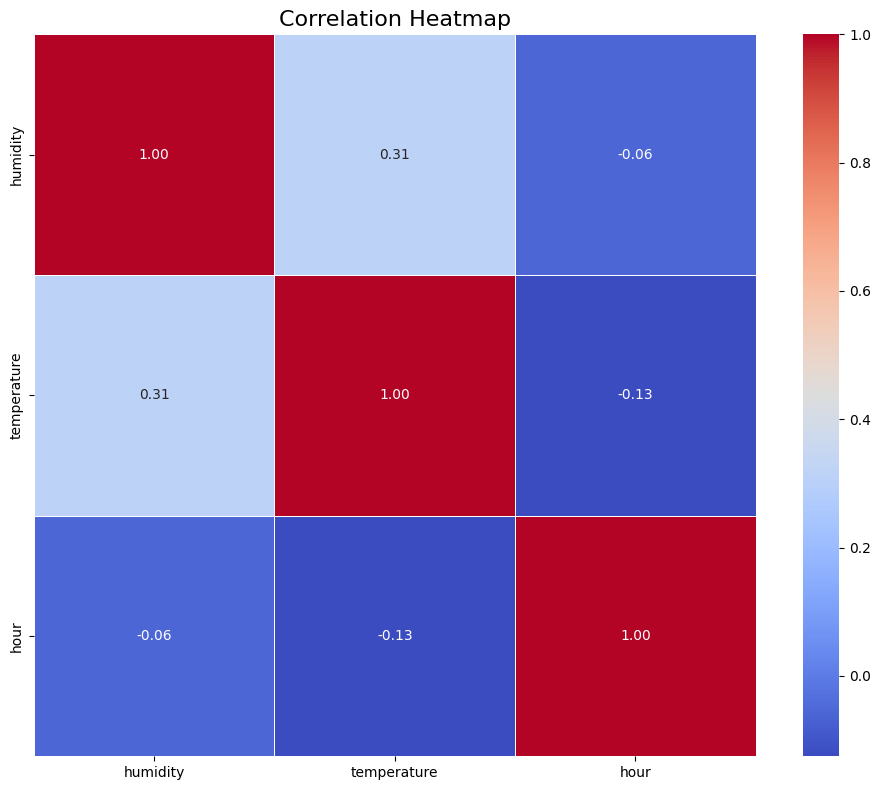

In [120]:
plot_corr_heatmap(df=df)

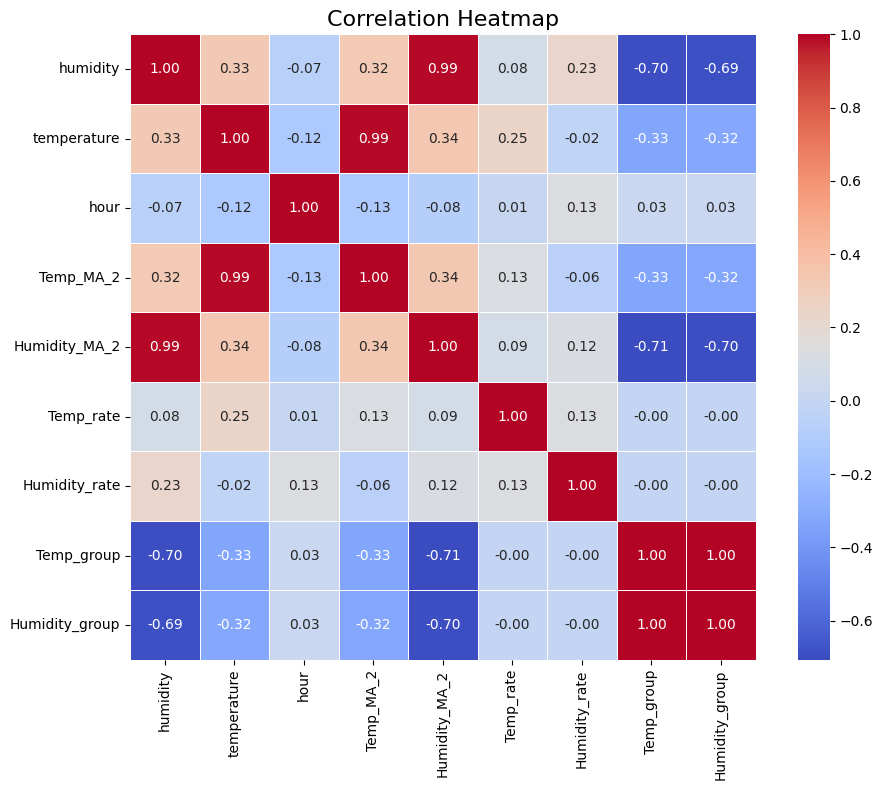

In [121]:
plot_corr_heatmap(df=hourly)

In [122]:
hourly.to_csv("Hourly_summary.csv",index=False)

In [123]:
hourly.value_counts('Temp_phase')

Temp_phase
Heating    411
Cooling    388
Neutral    215
Name: count, dtype: int64

In [124]:
def dual_axis_plot(df, x, y1, y2, **kwargs):
    """
    Creates a dual-axis line chart (Plotly).
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    x : str
        Column for x-axis.
    y1 : str
        Primary y-axis column (left).
    y2 : str
        Secondary y-axis column (right).
    **kwargs :
        title, line colors, axis labels, width, height, template, etc.
    """

    # ---- Defaults if not provided ----
    title = kwargs.get("title", f"{y1} and {y2} vs {x}")
    template = kwargs.get("template", "plotly_white")
    width = kwargs.get("width", 1000)
    height = kwargs.get("height", 500)

    y1_color = kwargs.get("y1_color", "red")     # Default primary axis color
    y2_color = kwargs.get("y2_color", "blue")    # Default secondary axis color

    y1_label = kwargs.get("y1_label", y1)
    y2_label = kwargs.get("y2_label", y2)
    x_label  = kwargs.get("x_label", x)

    # ---- Figure with two y-axes ----
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # ---- Primary axis trace ----
    fig.add_trace(
        go.Scatter(
            x=df[x],
            y=df[y1],
            name=y1,
            line=dict(color=y1_color)
        ),
        secondary_y=False
    )

    # ---- Secondary axis trace ----
    fig.add_trace(
        go.Scatter(
            x=df[x],
            y=df[y2],
            name=y2,
            line=dict(color=y2_color)
        ),
        secondary_y=True
    )

    # ---- Update axes ----
    fig.update_yaxes(
        title_text=f"<b>{y1_label}</b>",
        title_font=dict(color=y1_color),
        secondary_y=False,
        showgrid=False
    )

    fig.update_yaxes(
        title_text=f"<b>{y2_label}</b>",
        title_font=dict(color=y2_color),
        secondary_y=True,
        showgrid=True
    )

    fig.update_xaxes(
        title_text=f"<b>{x_label}</b>",
        showgrid=True
    )

    # ---- Layout ----
    fig.update_layout(
        title=title,
        width=width,
        height=height,
        template=template
    )

    fig.show()

In [125]:
dual_axis_plot(
    df=hourly,
    x="device_time",
    y1="temperature",
    y2="humidity",
    title="Temperature & Humidity Over Time",
    y1_label="Temperature (°C)",
    y2_label="Humidity (%)",
    y1_color="red",
    y2_color="blue",
    template="plotly_white"
)


In [126]:
daytime_aggregation_table = hourly.groupby(['daytime_labels'])[['temperature', 'humidity']].mean()

In [127]:
# Ensure correct order of daytime segments
order = ["late night", "early morning", "morning", "afternoon", "evening", "night"]



# Reset index so daytime_labels becomes a column
df_plot = daytime_aggregation_table.reset_index()

# Sort rows by correct daytime order
df_plot['daytime_labels'] = pd.Categorical(df_plot['daytime_labels'], categories=order, ordered=True)
df_plot = df_plot.sort_values('daytime_labels')

In [128]:


def plot_line_multi(df, x, y, **kwargs):
    """
    Generic Plotly line chart function.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    x : str
        Column to use on x-axis.
    y : list
        List of column names to plot on y-axis.
    **kwargs : 
        Additional parameters like:
        - title
        - width
        - height
        - template
        - line_width
        - marker_size
        ...and anything else for flexibility.
    """
    
    # Defaults (if not provided)
    title = kwargs.get("title", "Line Plot")
    template = kwargs.get("template", "plotly_white")
    width = kwargs.get("width", 900)
    height = kwargs.get("height", 500)
    line_width = kwargs.get("line_width", 3)
    marker_size = kwargs.get("marker_size", 8)

    fig = go.Figure()

    for col in y:
        fig.add_trace(go.Scatter(
            x=df[x],
            y=df[col],
            mode='lines+markers',
            name=col,
            line=dict(width=line_width),
            marker=dict(size=marker_size)
        ))

    fig.update_layout(
        title=title,
        xaxis_title=x,
        yaxis_title="Value",
        template=template,
        width=width,
        height=height
    )

    fig.show()

In [129]:
plot_line_multi(
    df=df_plot,
    x="daytime_labels",
    y=["humidity", "temperature"],
    title="Humidity & Temperature vs Daytime Labels",
    line_width=4,
    marker_size=10,
    template="plotly_white"
)


In [130]:
def plot_dual_axis_rates(
    df, 
    x_col, 
    y1_col, 
    y2_col, 
    **kwargs
):
    """
    Create a dual-axis plot (temperature rate vs humidity rate)
    using Plotly with configurable customization via kwargs.
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe
    x_col : str
        Column for x-axis (time)
    y1_col : str
        Primary y-axis column (Temperature rate)
    y2_col : str
        Secondary y-axis column (Humidity rate)
    **kwargs : dict
        Any extra keyword arguments for customizing:
            - title
            - y1_name
            - y2_name
            - width
            - height
            - line1_color
            - line2_color
            - dash2
    """

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Defaults (overridden by kwargs)
    title = kwargs.get("title", "Temperature & Humidity Rate Over Time")
    y1_name = kwargs.get("y1_name", "Temp Rate (°C/hr)")
    y2_name = kwargs.get("y2_name", "Humidity Rate (%/hr)")
    line1_color = kwargs.get("line1_color", "red")
    line2_color = kwargs.get("line2_color", "blue")
    dash2 = kwargs.get("dash2", "dot")
    width = kwargs.get("width", 1100)
    height = kwargs.get("height", 500)

    # --- Primary Y Axis Trace ---
    fig.add_trace(
        go.Scatter(
            x=df[x_col],
            y=df[y1_col],
            mode="lines",
            name=y1_name,
            line=dict(color=line1_color, width=2),
            hovertemplate="Time: %{x}<br>"+y1_name+": %{y:.2f}<extra></extra>"
        ),
        secondary_y=False
    )

    # --- Secondary Y Axis Trace ---
    fig.add_trace(
        go.Scatter(
            x=df[x_col],
            y=df[y2_col],
            mode="lines",
            name=y2_name,
            line=dict(color=line2_color, width=2, dash=dash2),
            hovertemplate="Time: %{x}<br>"+y2_name+": %{y:.2f}<extra></extra>"
        ),
        secondary_y=True
    )

    # Common Y-range
    y_min = min(df[y1_col].min(), df[y2_col].min())
    y_max = max(df[y1_col].max(), df[y2_col].max())

    # Update axes
    fig.update_yaxes(title_text=y1_name, range=[y_min, y_max], secondary_y=False)
    fig.update_yaxes(title_text=y2_name, range=[y_min, y_max], secondary_y=True)
    fig.update_xaxes(title_text="Time")

    # Horizontal zero lines
    fig.add_hline(y=0, line=dict(color="black", dash="dash"), opacity=0.6, secondary_y=False)
    fig.add_hline(y=0, line=dict(color="grey", dash="dot"), opacity=0.6, secondary_y=True)

    # Layout
    fig.update_layout(
        title=title,
        width=width,
        height=height,
        template="plotly_white"
    )

    fig.show()

In [131]:
plot_dual_axis_rates(
    hourly,
    x_col="device_time",
    y1_col="Temp_rate",
    y2_col="Humidity_rate",
    title="Temperature and Humidity Rate Comparison",
    line1_color="darkred",
    line2_color="blue",
    height=600
    
)


In [132]:

def plot_ma_with_phase(
    df, 
    x_col, 
    y_col, 
    phase_col, 
    **kwargs
):
    """
    Plot a moving average line + colored markers by Heating/Cooling phase.
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe
    x_col : str
        X-axis column
    y_col : str
        Temperature moving average column
    phase_col : str
        Column with categorical phases (e.g., Heating / Cooling)
    **kwargs : dict
        Optional custom styling such as:
        - title
        - ma_color
        - marker_heating_color
        - marker_cooling_color
        - marker_size
        - width, height
    """

    # Defaults that can be overridden via kwargs
    title = kwargs.get("title", "Temperature MA Colored by Phase")
    ma_color = kwargs.get("ma_color", "green")
    marker_heating_color = kwargs.get("marker_heating_color", "red")
    marker_cooling_color = kwargs.get("marker_cooling_color", "blue")
    marker_size = kwargs.get("marker_size", 6)
    width = kwargs.get("width", 1100)
    height = kwargs.get("height", 500)

    # Map phase colors dynamically
    phase_color_map = {
        'Heating': marker_heating_color,
        'Cooling': marker_cooling_color
    }

    # --- Create figure ---
    fig = go.Figure()

    # 1. MA Line
    fig.add_trace(go.Scatter(
        x=df[x_col],
        y=df[y_col],
        mode='lines',
        name=f"{y_col} (MA)",
        line=dict(color=ma_color, width=1.8)
    ))

    # 2. Markers colored by phase
    fig.add_trace(go.Scatter(
        x=df[x_col],
        y=df[y_col],
        mode='markers',
        name="Phase",
        marker=dict(
            size=marker_size,
            color=df[phase_col].map(phase_color_map),
            line=dict(width=1, color="DarkSlateGrey")
        ),
        customdata=df[[phase_col]].values,
        hovertemplate=(
            "Time: %{x}<br>"
            f"{y_col}: "+"%{y:.2f}<br>"
            f"Phase: "+"%{customdata[0]}<extra></extra>"
        )
    ))

    # Layout
    fig.update_layout(
        title=f"<b>{title}</b>",
        xaxis_title="Time",
        yaxis_title="Temperature (°C)",
        template="plotly_white",
        width=width,
        height=height,
        legend=dict(yanchor="top", y=1.15, xanchor="right", x=0.99)
    )

    fig.show()


In [133]:
plot_ma_with_phase(
    hourly,
    x_col="device_time",
    y_col="Temp_MA_2",
    phase_col="Temp_phase",
    title="Temp MA (2h) – Heating vs Cooling",
    ma_color="green",
    marker_heating_color="crimson",
    marker_cooling_color="royalblue",
    marker_size=7
)



In [134]:
def plot_timeline(data: pd.DataFrame,start_col: str,end_col: str,phase_col: str,color_map: dict,show: bool = False,**kwargs):
    """
    Create a timeline chart showing temperature phases (e.g., Heating/Cooling).

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing start, end, and phase columns.
    start_col : str, default='start_time'
        Column representing the start of each phase.
    end_col : str, default='end_time'
        Column representing the end of each phase.
    phase_col : str, default='phase'
        Column representing the phase category (e.g., Heating, Cooling).
    color_map : dict, optional
        Custom color mapping for phases, e.g., {'Heating':'red', 'Cooling':'blue'}.
    **kwargs :
        Additional keyword arguments forwarded to px.timeline().
        Examples: title, hover_data, height, template, category_orders, etc.

    Returns
    -------
    plotly.graph_objects.Figure
        The Plotly timeline figure.
    """
    try:
        # Default color map if not provided
        if color_map is None:
            color_map = {"Heating": "red", "Cooling": "blue"}

        # Default hover fields
        hover_defaults = {"delta": True, start_col: True, end_col: True}
        hover_data = kwargs.pop("hover_data", hover_defaults)

        fig = px.timeline(
            data,
            x_start=start_col,
            x_end=end_col,
            y=phase_col,
            color=phase_col,
            color_discrete_map=color_map,
            hover_data=hover_data,
            **kwargs
        )

        # Order y-axis (Heating above Cooling)
        fig.update_yaxes(categoryorder="array", categoryarray=["Heating", "Cooling"])

        # Layout customization
        fig.update_layout(
            xaxis_title="Time",
            yaxis_title="Phase Type",
            template=kwargs.pop("template", "plotly_white"),
            height=kwargs.pop("height", 400)
        )

        if show:
            fig.show()
        return fig
    except Exception as e:
        print(f"Error creating temperature timeline: {e}")
        raise

In [135]:
temp_phase_chart = plot_timeline(
    temp_cycles,
    start_col="start_time",
    end_col='end_time',
    phase_col='phase',
    color_map={'Heating': 'red', 'Cooling': 'blue'},
    title="Temperature Phases",
    hover_data={'start_time': True, 'end_time': True, 'delta': True},
    height=500,
    template="simple_white",
    show=False
)

temp_phase_chart.show()



In [136]:
humidit_phase_chart = plot_timeline(
    humidity_cycles,
    start_col="start_time",
    end_col='end_time',
    phase_col='phase',
    color_map={'Drying': 'red', 'Moistening': 'green','Moderate': "blue"},
    title="Humidity Phases",
    hover_data={'start_time': True, 'end_time': True, 'delta': True},
    height=500,
    template="simple_white",
    show=False
)

humidit_phase_chart.show()

In [137]:
temp_cycles.columns

Index(['phase', 'start_time', 'end_time', 'start', 'end', 'duration', 'delta',
       'rate'],
      dtype='object')

In [138]:
temp_cycles

phase          start_time            end_time  start    end  \
Temp_group                                                                  
2           Heating 2025-10-05 06:00:00 2025-10-05 07:00:00  27.05  27.10   
4           Heating 2025-10-05 09:00:00 2025-10-05 11:00:00  27.25  27.90   
5           Cooling 2025-10-05 12:00:00 2025-10-05 17:00:00  27.80  24.25   
6           Heating 2025-10-05 18:00:00 2025-10-06 00:00:00  25.15  26.85   
8           Heating 2025-10-06 02:00:00 2025-10-06 03:00:00  26.95  27.00   
...             ...                 ...                 ...    ...    ...   
331         Cooling 2025-11-19 06:00:00 2025-11-19 08:00:00  26.50  25.50   
332         Heating 2025-11-19 09:00:00 2025-11-19 10:00:00  25.85  26.10   
333         Cooling 2025-11-19 11:00:00 2025-11-19 12:00:00  25.75  25.15   
335         Cooling 2025-11-19 15:00:00 2025-11-19 16:00:00  24.85  24.80   
336         Heating 2025-11-19 17:00:00 2025-11-19 20:00:00  24.90  25.85   

            duration  delta      rate  
Temp_group                             
2                  2   0.05  0.025000  
4                  3   0.65  0.216667  
5                  6  -3.55 -0.591667  
6                  7   1.70  0.242857  
8                  2   0.05  0.025000  
...              ...    ...       ...  
331                3  -1.00 -0.333333  
332                2   0.25  0.125000  
333                2  -0.60 -0.300000  
335                2  -0.05 -0.025000  
336                4   0.95  0.237500  

[174 rows x 8 columns]

In [139]:
hourly.tail(30)

device_time  humidity  temperature  hour  Temp_MA_2  \
1073 2025-11-18 17:00:00      44.4         25.3    17      25.10   
1074 2025-11-18 18:00:00      42.2         26.1    18      25.70   
1075 2025-11-18 19:00:00      43.2         26.3    19      26.20   
1076 2025-11-18 20:00:00      46.9         25.7    20      26.00   
1077 2025-11-18 21:00:00      48.8         26.0    21      25.85   
1078 2025-11-18 22:00:00      49.6         26.1    22      26.05   
1079 2025-11-18 23:00:00      50.8         26.2    23      26.15   
1080 2025-11-19 00:00:00      50.6         26.4     0      26.30   
1081 2025-11-19 01:00:00      51.3         26.5     1      26.45   
1082 2025-11-19 02:00:00      51.7         26.5     2      26.50   
1083 2025-11-19 03:00:00      51.9         26.5     3      26.50   
1084 2025-11-19 04:00:00      52.5         26.6     4      26.55   
1085 2025-11-19 05:00:00      52.9         26.6     5      26.60   
1086 2025-11-19 06:00:00      52.7         26.4     6      26.50   
1087 2025-11-19 07:00:00      54.1         25.4     7      25.90   
1088 2025-11-19 08:00:00      49.8         25.6     8      25.50   
1089 2025-11-19 09:00:00      46.7         26.1     9      25.85   
1090 2025-11-19 10:00:00      44.8         26.1    10      26.10   
1091 2025-11-19 11:00:00      49.2         25.4    11      25.75   
1092 2025-11-19 12:00:00      51.0         24.9    12      25.15   
1093 2025-11-19 13:00:00      47.1         25.4    13      25.15   
1094 2025-11-19 14:00:00      47.1         24.8    14      25.10   
1095 2025-11-19 15:00:00      45.5         24.9    15      24.85   
1096 2025-11-19 16:00:00      44.9         24.7    16      24.80   
1097 2025-11-19 17:00:00      49.4         25.1    17      24.90   
1098 2025-11-19 18:00:00      51.0         25.7    18      25.40   
1099 2025-11-19 19:00:00      49.5         25.8    19      25.75   
1100 2025-11-19 20:00:00      47.2         25.9    20      25.85   
1101 2025-11-19 21:00:00      49.5         25.6    21      25.75   
1102 2025-11-19 22:00:00      48.1         25.8    22      25.70   

      Humidity_MA_2  Temp_rate  Humidity_rate Temp_phase Humidity_phase  \
1073          44.05       0.05           2.35    Heating     Moistening   
1074          43.30       0.60          -0.75    Heating         Drying   
1075          42.70       0.50          -0.60    Heating         Drying   
1076          45.05      -0.20           2.35    Cooling     Moistening   
1077          47.85      -0.15           2.80    Cooling     Moistening   
1078          49.20       0.20           1.35    Heating     Moistening   
1079          50.20       0.10           1.00    Heating     Moistening   
1080          50.70       0.15           0.50    Heating     Moistening   
1081          50.95       0.15           0.25    Heating     Moistening   
1082          51.50       0.05           0.55    Heating     Moistening   
1083          51.80       0.00           0.30    Neutral     Moistening   
1084          52.20       0.05           0.40    Heating     Moistening   
1085          52.70       0.05           0.50    Heating     Moistening   
1086          52.80      -0.10           0.10    Cooling     Moistening   
1087          53.40      -0.60           0.60    Cooling     Moistening   
1088          51.95      -0.40          -1.45    Cooling         Drying   
1089          48.25       0.35          -3.70    Heating         Drying   
1090          45.75       0.25          -2.50    Heating         Drying   
1091          47.00      -0.35           1.25    Cooling     Moistening   
1092          50.10      -0.60           3.10    Cooling     Moistening   
1093          49.05       0.00          -1.05    Neutral         Drying   
1094          47.10      -0.05          -1.95    Neutral         Drying   
1095          46.30      -0.25          -0.80    Cooling         Drying   
1096          45.20      -0.05          -1.10    Cooling         Drying   
1097          47.15       0.1

In [140]:
temp_cycles

phase          start_time            end_time  start    end  \
Temp_group                                                                  
2           Heating 2025-10-05 06:00:00 2025-10-05 07:00:00  27.05  27.10   
4           Heating 2025-10-05 09:00:00 2025-10-05 11:00:00  27.25  27.90   
5           Cooling 2025-10-05 12:00:00 2025-10-05 17:00:00  27.80  24.25   
6           Heating 2025-10-05 18:00:00 2025-10-06 00:00:00  25.15  26.85   
8           Heating 2025-10-06 02:00:00 2025-10-06 03:00:00  26.95  27.00   
...             ...                 ...                 ...    ...    ...   
331         Cooling 2025-11-19 06:00:00 2025-11-19 08:00:00  26.50  25.50   
332         Heating 2025-11-19 09:00:00 2025-11-19 10:00:00  25.85  26.10   
333         Cooling 2025-11-19 11:00:00 2025-11-19 12:00:00  25.75  25.15   
335         Cooling 2025-11-19 15:00:00 2025-11-19 16:00:00  24.85  24.80   
336         Heating 2025-11-19 17:00:00 2025-11-19 20:00:00  24.90  25.85   

            duration  delta      rate  
Temp_group                             
2                  2   0.05  0.025000  
4                  3   0.65  0.216667  
5                  6  -3.55 -0.591667  
6                  7   1.70  0.242857  
8                  2   0.05  0.025000  
...              ...    ...       ...  
331                3  -1.00 -0.333333  
332                2   0.25  0.125000  
333                2  -0.60 -0.300000  
335                2  -0.05 -0.025000  
336                4   0.95  0.237500  

[174 rows x 8 columns]

In [141]:
data.tail(30)

device_time  humidity  temperature
165320 2025-11-19 22:24:42      48.7         25.2
165321 2025-11-19 22:24:56      49.0         25.2
165322 2025-11-19 22:25:09      49.4         25.1
165323 2025-11-19 22:25:23      49.8         25.1
165324 2025-11-19 22:25:36      50.2         25.1
165325 2025-11-19 22:25:51      50.4         25.1
165326 2025-11-19 22:26:04      50.7         25.1
165327 2025-11-19 22:26:18      51.6         25.1
165328 2025-11-19 22:26:31      52.2         25.1
165329 2025-11-19 22:26:45      52.7         25.0
165330 2025-11-19 22:26:58      52.8         25.0
165331 2025-11-19 22:27:12      53.1         25.0
165332 2025-11-19 22:27:25      54.1         25.0
165333 2025-11-19 22:27:39      54.5         25.0
165334 2025-11-19 22:27:52      55.1         25.0
165335 2025-11-19 22:28:06      55.6         25.0
165336 2025-11-19 22:28:19      55.8         25.0
165337 2025-11-19 22:28:33      56.2         25.0
165338 2025-11-19 22:28:46      56.7         25.0
165339 2025-11-19 22:29:01      56.6         25.0
165340 2025-11-19 22:29:14      56.6         24.9
165341 2025-11-19 22:29:28      56.9         24.9
165342 2025-11-19 22:30:21      56.8         24.9
165343 2025-11-19 22:30:25      56.3         24.9
165344 2025-11-19 22:30:38      56.2         24.9
165345 2025-11-19 22:30:54      55.9         24.9
165346 2025-11-19 22:31:09      55.7         24.9
165347 2025-11-19 22:31:24      55.3         24.9
165348 2025-11-19 22:31:39      55.0         24.8
165349 2025-11-19 22:31:54      54.7         24.8

In [142]:
def plot_relationship(data: pd.DataFrame, col1: str, col2: str, color: Optional[str]=None,hover_data: Optional[list]=None):
    """
    Return an interactive scatter plotly figure.
    trendline can be 'ols' to show linear regression (uses statsmodels if installed) or None.
    """
    for col in (col1, col2):
        if col not in data.columns:
            raise KeyError(f"Column '{col}' not found.")
    fig = px.scatter(data, x=col1, y=col2, color=color, hover_data=hover_data,
                     labels={col1: col1, col2: col2}, title=f"{col1.capitalize()} vs {col2.capitalize()}")
    fig.update_traces(marker=dict(size=6, opacity=0.7))
    fig.update_layout(template='plotly_white')
    return fig

In [143]:
plot_relationship(df,col1='temperature',col2='humidity', hover_data=['temperature','humidity'])


In [144]:
def get_distribution_type(data: pd.DataFrame, feature: str, nbins: int = 30, marginal: Optional[str] = None):
    """
    Return a Plotly Figure (histogram) for distribution.
    marginal: 'rug' | 'box' | None
    """
    if feature not in data.columns:
        raise KeyError(f"Feature '{feature}' not found.")
    fig = px.histogram(data, x=feature, nbins=nbins, marginal=marginal,
                       title=f"Distribution of {feature}", labels={feature: feature})
    fig.update_layout(bargap=0.05, template='plotly_white')
    return fig


def check_outliers(data: pd.DataFrame, feature: str, **kwargs):
    """
    Visualize outliers for a given feature using a Seaborn boxplot.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the feature.
    feature : str
        The column name to visualize for outliers.
    **kwargs :
        Additional keyword arguments to customize seaborn.boxplot().
        Examples: color='skyblue', orient='v', width=0.5, showcaps=False
    """
    try:
        plt.figure(figsize=kwargs.pop('figsize', (6, 3)))  # optional figure size
        sns.boxplot(data=data, x=feature, **kwargs)
        plt.title(f"Outlier Check: {feature}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting feature '{feature}': {e}")
        raise

In [145]:
get_distribution_type(data=hourly, feature='humidity', nbins=20)

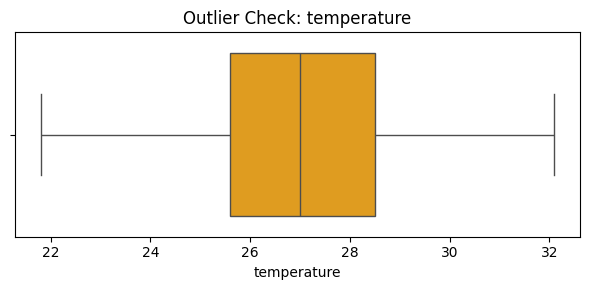

In [146]:
check_outliers(data=hourly, feature='temperature', color='orange')

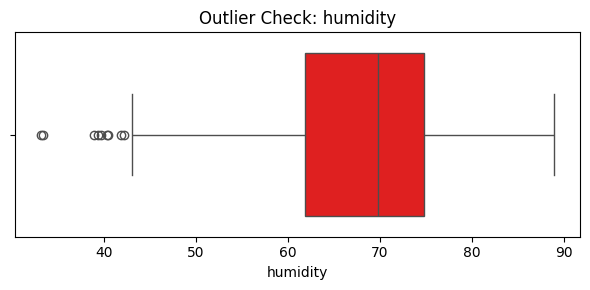

In [147]:
check_outliers(data=hourly, feature='humidity',color='red')

In [148]:
outliers_data = len(np.where(hourly['humidity'] < 50)[0])
data_length = len(hourly.index)

In [149]:
outliers_data

67

In [150]:
(outliers_data / data_length) * 100

6.607495069033531

In [151]:
hourly.corr(numeric_only=True)

humidity  temperature      hour  Temp_MA_2  Humidity_MA_2  \
humidity        1.000000     0.330357 -0.065963   0.321240       0.987952   
temperature     0.330357     1.000000 -0.120420   0.987621       0.342215   
hour           -0.065963    -0.120420  1.000000  -0.125614      -0.077046   
Temp_MA_2       0.321240     0.987621 -0.125614   1.000000       0.335636   
Humidity_MA_2   0.987952     0.342215 -0.077046   0.335636       1.000000   
Temp_rate       0.083922     0.246112  0.008966   0.125020       0.086605   
Humidity_rate   0.226981    -0.022323  0.128631  -0.057064       0.116903   
Temp_group     -0.699093    -0.328342  0.025917  -0.332600      -0.706743   
Humidity_group -0.691522    -0.316999  0.025516  -0.321074      -0.699095   

                Temp_rate  Humidity_rate  Temp_group  Humidity_group  
humidity         0.083922       0.226981   -0.699093       -0.691522  
temperature      0.246112      -0.022323   -0.328342       -0.316999  
hour             0.008966       0.128631    0.025917        0.025516  
Temp_MA_2        0.125020      -0.057064   -0.332600       -0.321074  
Humidity_MA_2    0.086605       0.116903   -0.706743       -0.699095  
Temp_rate        1.000000       0.131645   -0.002966       -0.003183  
Humidity_rate    0.131645       1.000000   -0.004769       -0.004476  
Temp_group      -0.002966      -0.004769    1.000000        0.999093  
Humidity_group  -0.003183      -0.004476    0.999093        1.000000